In [18]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import ceil
from tqdm import tqdm

In [19]:
I = np.eye(2)

X = np.array([[0, 1],
              [1, 0]])

Z = np.array([[1,  0],
              [0, -1]])

In [20]:
# генерирует чистое состояние
def gen_psi(d, k):
    c = np.random.randn(d*k) + 1j*np.random.randn(d*k)
    c = c/((abs(c)**2).sum()**0.5)
    return c

# считает Purity первого кубита 
def p(psi):
    N = psi.shape[0]//2
    Psi = np.reshape(psi, (2, N))
    rho_ = Psi@np.conjugate(Psi.T)
    return np.trace(rho_ @ rho_)

# 1. Немарковская динамика

In [21]:
# 1-кубитное преобразование
def gate_1d(state, U1, k):
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask = 1 << n-1-k
    for ind in range(dim):
        for jk in range(2):
            b[ind] += state[ind - (ind&mask)+(jk << n-1-k)]*U1[int((ind & mask) != 0), jk]
    return b

# 2-кубитное преобразование
def gate_2d(state, U2, l, k): 
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask_k, mask_l = (1 << n-1-k) , (1 << n-1-l)
    mask = mask_k + mask_l
    for ind in range(dim):
        for jk in range(2):
            for jl in range(2):
                b[ind] += state[ind - (ind&mask)+(jk << n-1-k)+(jl << n-1-l)]*U2[int((ind & mask_k) != 0) +\
                                                                        (int((ind & mask_l) != 0) << 1), jk+(jl<<1)]
    return b

In [22]:
n =  4

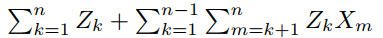

In [23]:
# Функции для расширения однокубитных и двухкубитных гейтов на все гильбертово пространство
def expand_1d_to_all(U, i, n):
    return np.kron(np.kron(np.eye(2**i), U), np.eye(2**(n-i-1)))

def expand_2d_to_all(U1, U2, i, j, n):
    return np.kron(np.kron(np.kron(np.kron(np.eye(2**i), U1), np.eye(2**(j-i-1))), U2), np.eye(2**(n-j-1)))

In [24]:
# Создадим гамильтониан
H = np.zeros((2**n, 2**n))
gate_1d_qubits = np.zeros(n, dtype=int)
gate_2d_qubits = np.zeros(n*(n-1)//2, dtype=object)

for i in range(n):
    H += expand_1d_to_all(Z, i, n)
    gate_1d_qubits[i] = i

i = 0
for k in range(n-1):
    for m in range(k+1, n):
        H += expand_2d_to_all(Z, X, k, m, n)
        gate_2d_qubits[i] = np.array([k, m])
        i+=1

In [59]:
# Создадим состояние
np.random.seed(0)
psi_ = gen_psi(2, 1)
psi0 = np.kron(psi_, gen_psi(2**(n-1), 1))
rho0 = np.outer(psi0, np.conj(psi0))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


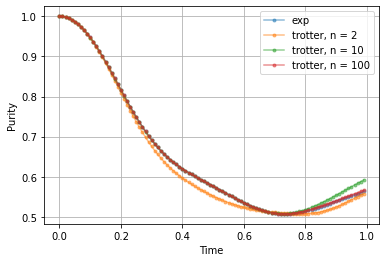

In [120]:
dt = 0.01
psi = psi0
t_max = 1

ts = np.arange(0, t_max, dt)
psis_exp = np.zeros(ts.shape[0], dtype=object)
purities = np.zeros(0)
errors = np.zeros(0)

# Воспользуемся оператором эволюции
for t in tqdm(range(ts.shape[0])):
    psi = la.expm(-1j*H*ts[t])@psi0
    psis_exp[t] = psi
    purities = np.append(purities, p(psi).real)
plt.plot(ts, purities, '.-', alpha=0.5, label='exp')

# Воспользуемся троттеризацией
for trotter_n in [2, 10, 100]:

    ZX = np.kron(Z, X)
    ZZ = np.kron(Z, Z)

    psi = psi0
    purities = np.zeros(0)
    
    # Будем действовать экспонентами в течение времени t
    for t in tqdm(range(ts.shape[0])):
        psi = psi0
        # Создадим массивы одно/двухкубитных экспонент для эволюции
        gates_1d = n*[la.expm(-1j*ts[t]*Z/trotter_n)]
        gates_2d = n*(n-1)//2*[la.expm(-1j*ts[t]*ZX/trotter_n)]
        # И n раз в каждый момент времени
        for j in range(trotter_n):
            for i in range(n):
                psi = gate_1d(psi, gates_1d[i], gate_1d_qubits[i])
            for i in range(n*(n-1)//2):
                psi = gate_2d(psi, gates_2d[i], *gate_2d_qubits[i])
        # Посчитаем ошибки как инфиделити        
        errors = np.append(errors, 1 - abs(np.conj(psis_exp[t]) @ psi)**2)
        purities = np.append(purities, p(psi).real)
    plt.plot(ts, purities, '.-', alpha=0.5, label='trotter, n = '+str(trotter_n))
errors = np.reshape(errors, (3, ts.shape[0]))

plt.grid()
plt.ylabel('Purity')
plt.xlabel('Time')
plt.legend()
plt.show()

In [97]:
ps = np.zeros(len(psis_exp), complex)
for i in range(7):
    ps[i] = np.conj(psis_exp[i])@psis_exp[i]

In [118]:
psis_exp[29]

0

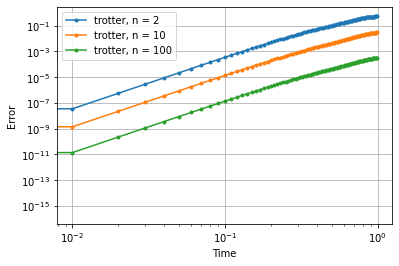

In [123]:
# Построим графики ошибок
for i in range(3):
    plt.plot(ts, errors[i], '.-', label='trotter, n = '+ str([2, 10, 100][i]))
plt.grid()
plt.ylabel('Error')
plt.xlabel('Time')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

# 2. Эффект спинового эха

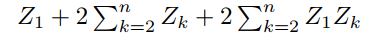

In [28]:
n_ = 7

In [29]:
# Создадим гамильтониан
H_ = np.zeros((2**n, 2**n))

H_ = expand_1d_to_all(Z, 0, n)

for i in range(1, n):
    H_ += expand_1d_to_all(2*Z, i, n)
    
for i in range(1, n):
    H_ += expand_2d_to_all(Z, Z, 0, i, n)

In [30]:
# Создадим состояние
np.random.seed(2)
psi__ = gen_psi(2, 1)
psi0_ = np.kron(psi__, gen_psi(2**(n-1), 1))
rho0_ = np.outer(psi0_, np.conj(psi0_))

In [31]:
# Функция для вычисления недиагонального элемента матрицы плотности первого кубита
def get_non_diag(psi):
    N = psi.shape[0]//2
    Psi = np.reshape(psi, (2, N))
    rho_ = Psi@np.conjugate(Psi.T)
    return rho_[0, 1]

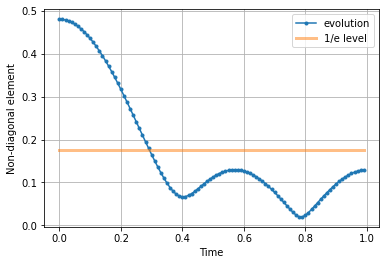

In [124]:
dt = 0.01
psi = psi0_

rhos_01 = np.zeros(0)
time = np.arange(0, 1, dt)

# Воспользуемся оператором эволюции
for t in time:
    psi = la.expm(-1j*H_*t)@psi0_
    rhos_01 = np.append(rhos_01, get_non_diag(psi))

plt.plot(time, abs(rhos_01), '.-', label='evolution')
plt.plot(time, np.zeros(time.shape[0])+abs(rhos_01[0])/np.e, '-', alpha=0.5, lw=3, label='1/e level')
plt.grid()
plt.ylabel('Non-diagonal element')
plt.xlabel('Time')
plt.legend()
plt.show()

In [33]:
rhos_01_interp =  interp1d(abs(rhos_01[time < 0.35]), time[time < 0.35])
T2 = float(rhos_01_interp(abs(rhos_01[0])/np.e))

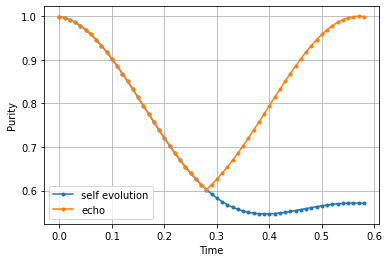

In [135]:
dt = 0.01
psi = psi0_

purities_ = np.zeros(0)
purities_echo = np.zeros(0)
time = np.arange(0, 2*T2, dt)
half_time = time[:time.shape[0]//2]
second_half_time = time[time.shape[0]//2:]
# Воспользуемся оператором эволюции
for t in half_time:
    psi = la.expm(-1j*H_*dt)@psi
    purities_ = np.append(purities_, p(psi).real)
    purities_echo = np.append(purities_echo, p(psi).real)

# Применим X-гейт к первому кубиту
psi_echo = gate_1d(psi, X, 0)

for t in second_half_time:
    psi = la.expm(-1j*H_*dt)@psi
    psi_echo = la.expm(-1j*H_*dt)@psi_echo
    purities_ = np.append(purities_, p(psi).real)
    purities_echo = np.append(purities_echo, p(psi_echo).real)

plt.plot(time, purities_, '.-', label='self evolution')
plt.plot(time, purities_echo, '.-', label='echo')
plt.grid()
plt.ylabel('Purity')
plt.xlabel('Time')
plt.legend()
plt.show()